In [1]:
import jax 
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import model_jax as model

In [4]:
import optax

In [5]:
from flax import linen as nn
from flax.training import train_state

In [6]:
key0, key1 = random.split(key=random.PRNGKey(1), num=2)

2024-07-28 20:31:56.490504: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
train_test =  jnp.asarray(random.normal(key0, (100, 1, 40)))

In [8]:
print((train_test+1e-10).shape)

(100, 1, 40)


In [106]:
@jax.jit
def dropout(loss, sigma, w, thr):
    val = w/jnp.exp(sigma)
    mask = jnp.where(val>thr, 1., 0.)
    return jnp.mean(loss*mask)

In [102]:
@jax.jit
def loss_fn_ws(params, state, inputs, target, mu_filter, sigma_filter, w_filter, ratio):
    predicts = state.apply_fn(params, inputs)
    mu_predict = jnp.matmul(predicts, mu_filter)
    sigma_predict = jnp.matmul(predicts, sigma_filter)
    w_predict = jnp.matmul(predicts, w_filter)

    mu_target = jnp.matmul(target, mu_filter)
    sigma_target = jnp.matmul(target, sigma_filter)
    w_target = jnp.matmul(target, w_filter)

    mu_diff = mu_predict - mu_target
    sigma_diff = (sigma_predict - sigma_target)


    #loss = jnp.mean(w_target * (mu_diff**2 / sigma_predict + (jnp.exp(sigma_diff) - jnp.exp(-sigma_diff))**2)) + jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-10))) 
    #loss = jnp.mean(w_target * (mu_diff**2 +  sigma_diff**2 + ratio*jnp.log(w_target/(w_predict+1e-10)))) + ratio*jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-10)))
    loss = w_target * (mu_diff**2 +  sigma_diff**2) + ratio*w_target*(w_predict/(w_target+1e-6) - w_target/(w_predict+1e-10))**2
    #loss = optax.l2_loss(predicts, target).mean()
    loss = dropout(loss, sigma_target, w_target, 0.01)
    return loss

@jax.jit
def loss_fn_kl1(params, state, inputs, target, mu_filter, sigma_filter, w_filter, ratio):
    predicts = state.apply_fn(params, inputs)
    mu_predict = jnp.matmul(predicts, mu_filter)
    sigma_predict = jnp.matmul(predicts, sigma_filter)
    w_predict = jnp.matmul(predicts, w_filter)

    mu_target = jnp.matmul(target, mu_filter)
    sigma_target = jnp.matmul(target, sigma_filter)
    w_target = jnp.matmul(target, w_filter)

    mu_diff = mu_predict - mu_target
    sigma_diff = (sigma_predict - sigma_target)


    #loss = jnp.mean(w_target * ((mu_diff / jnp.exp(sigma_predict))**2 + (jnp.exp(sigma_diff/2) - jnp.exp(-sigma_diff/2))**2) + ratio*jnp.log(w_target/(w_predict+1e-10))) + ratio*jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-10)))
    loss = jnp.mean(w_target * ((mu_diff / jnp.exp(sigma_target))**2 + jnp.exp(sigma_diff)**2 - 1.0 - sigma_diff)) + ratio*jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-6))) 
    #loss = jnp.mean(w_target * (mu_diff**2 +  sigma_diff**2 + ratio*jnp.log(w_target/(w_predict+1e-10)))) + ratio*jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-10))) 
    #loss = optax.l2_loss(predicts, target).mean()
    return loss

@jax.jit
def loss_fn_kl3(params, state, inputs, target, mu_filter, sigma_filter, w_filter, ratio):
    predicts = state.apply_fn(params, inputs)
    mu_predict = jnp.matmul(predicts, mu_filter)
    sigma_predict = jnp.matmul(predicts, sigma_filter)
    w_predict = jnp.matmul(predicts, w_filter)

    mu_target = jnp.matmul(target, mu_filter)
    sigma_target = jnp.matmul(target, sigma_filter)
    w_target = jnp.matmul(target, w_filter)

    mu_diff = mu_predict - mu_target
    sigma_diff = (sigma_predict - sigma_target)


    #loss = jnp.mean(w_target * ((mu_diff / jnp.exp(sigma_predict))**2 + (jnp.exp(sigma_diff/2) - jnp.exp(-sigma_diff/2))**2) + ratio*jnp.log(w_target/(w_predict+1e-10))) + ratio*jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-10)))
    loss = w_target * ((mu_diff / jnp.exp(sigma_target))**2 + jnp.exp(sigma_diff) + jnp.exp(-sigma_diff) - 2.0) + ratio*w_predict*jnp.log(w_predict/(w_target+1e-10))
    #loss = jnp.mean(w_target * (mu_diff**2 +  sigma_diff**2 + ratio*jnp.log(w_target/(w_predict+1e-10)))) + ratio*jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-10))) 
    #loss = optax.l2_loss(predicts, target).mean()
    loss = dropout(loss, sigma_target, w_target, 0.01)
    return loss


@jax.jit
def loss_fn_kl2(params, state, inputs, target, mu_filter, sigma_filter, w_filter, ratio):
    predicts = state.apply_fn(params, inputs)
    mu_predict = jnp.matmul(predicts, mu_filter)
    sigma_predict = jnp.matmul(predicts, sigma_filter)
    w_predict = jnp.matmul(predicts, w_filter)

    mu_target = jnp.matmul(target, mu_filter)
    sigma_target = jnp.matmul(target, sigma_filter)
    w_target = jnp.matmul(target, w_filter)

    mu_diff = mu_predict - mu_target
    sigma_diff = (sigma_predict - sigma_target)


    #loss = jnp.mean(w_target * ((mu_diff / jnp.exp(sigma_predict))**2 + (jnp.exp(sigma_diff/2) - jnp.exp(-sigma_diff/2))**2) + ratio*jnp.log(w_target/(w_predict+1e-10))) + ratio*jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-10)))
    loss = jnp.mean(w_target * ((mu_diff / jnp.exp(sigma_predict))**2 + jnp.exp(-sigma_diff)**2 - 1.0 + sigma_diff)) + ratio*jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-6))) 
    #loss = jnp.mean(w_target * (mu_diff**2 +  sigma_diff**2 + ratio*jnp.log(w_target/(w_predict+1e-10)))) + ratio*jnp.mean(w_predict*jnp.log(w_predict/(w_target+1e-10))) 
    #loss = optax.l2_loss(predicts, target).mean()
    return loss

@jax.jit
def train_step_ws(state, inputs, target, mu_filter, sigma_filter, w_filter, ratio):
    loss, grad = jax.value_and_grad(loss_fn_ws)(state.params, state, inputs, target, mu_filter, sigma_filter, w_filter, ratio)
    #updates, new_state = state.tx.update(grad, state)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss

@jax.jit
def train_step_kl1(state, inputs, target, mu_filter, sigma_filter, w_filter, ratio):
    loss, grad = jax.value_and_grad(loss_fn_kl1)(state.params, state, inputs, target, mu_filter, sigma_filter, w_filter, ratio)
    #updates, new_state = state.tx.update(grad, state)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss

@jax.jit
def train_step_kl2(state, inputs, target, mu_filter, sigma_filter, w_filter, ratio):
    loss, grad = jax.value_and_grad(loss_fn_kl2)(state.params, state, inputs, target, mu_filter, sigma_filter, w_filter, ratio)
    #updates, new_state = state.tx.update(grad, state)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss

@jax.jit
def train_step_kl3(state, inputs, target, mu_filter, sigma_filter, w_filter, ratio):
    loss, grad = jax.value_and_grad(loss_fn_kl3)(state.params, state, inputs, target, mu_filter, sigma_filter, w_filter, ratio)
    #updates, new_state = state.tx.update(grad, state)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss


#@jax.jit 
def sample_batch(input, target, sample_size, rng):
    num_samples = input.shape[0]
    if sample_size > num_samples:
        sample_size = num_samples
    indices = jax.random.choice(rng, num_samples, shape=(sample_size,), replace=False)
    sampled_batch = input[indices,:,:]
    sampled_target = target[indices,:,:]
    return sampled_batch, sampled_target

In [10]:
csv_file = 'datas/input_32768_e15_K5_phiorder_1.csv'
df = pd.read_csv(csv_file)
data = jnp.transpose(jnp.array(df.values),[1,0])
print(data.shape)

input_data = data.reshape(data.shape[0], 1, data.shape[1])
print(input_data.shape)

(32768, 40)
(32768, 1, 40)


In [11]:
csv_file = 'datas/input_32768_e15_K5_phiorder_2.csv'
df = pd.read_csv(csv_file)
data = jnp.transpose(jnp.array(df.values),[1,0])
print(data.shape)

input_data2 = data.reshape(data.shape[0], 1, data.shape[1])
print(input_data2.shape)

(32768, 40)
(32768, 1, 40)


In [12]:
csv_file = 'datas/target_32768_e15_K5_phiorder_1.csv'
df = pd.read_csv(csv_file)
data = jnp.transpose(jnp.array(df.values),[1,0])
print(data.shape)

target_data = data.reshape(data.shape[0], 1, data.shape[1])
print(target_data.shape)

(32768, 15)
(32768, 1, 15)


In [13]:
csv_file = 'datas/target_32768_e15_K5_phiorder_2.csv'
df = pd.read_csv(csv_file)
data = jnp.transpose(jnp.array(df.values),[1,0])
print(data.shape)

target_data2 = data.reshape(data.shape[0], 1, data.shape[1])
print(target_data2.shape)

(32768, 15)
(32768, 1, 15)


In [14]:
n_gauss = 5
num_classes = 3*n_gauss

In [107]:
heads = 5
d_model = 40
n_layer = 16
var = model.TransformerEncoder(n_gauss, heads, d_model, n_layer).init(key1, train_test)
#state = train_state.TrainState.create(apply_fn=model.TransformerEncoder(n_gauss, heads, d_model, n_layer).apply, params=var, tx=optax.chain(optax.scale_by_adam(), optax.scale_by_learning_rate(optax.piecewise_constant_schedule(init_value=1e-3, boundaries_and_scales={1000: 0.3}))))
state = train_state.TrainState.create(apply_fn=model.TransformerEncoder(n_gauss, heads, d_model, n_layer).apply, params=var, tx=optax.chain(optax.scale_by_adam(), optax.scale_by_learning_rate(optax.exponential_decay(1e-4, 3000, 0.5, end_value=1e-6))))

In [16]:
indices_m = jnp.array(range(0, n_gauss))
mu_filter = (jnp.eye(num_classes)[indices_m]).transpose()

indice_s = jnp.array(range(n_gauss, 2*n_gauss))
sigma_filter = (jnp.eye(num_classes)[indice_s]).transpose()

indice_w = jnp.array(range(2*n_gauss, 3*n_gauss))
w_filter = (jnp.eye(num_classes)[indice_w]).transpose()
print(w_filter)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [17]:
inputs = [input_data, input_data2]
targets = [target_data, target_data2]

step: 3000, loss: 0.0022953622974455357
step: 6000, loss: 0.2872339189052582
step: 9000, loss: 0.0016241420526057482
step: 12000, loss: 0.2009427845478058
step: 15000, loss: 0.001481911400333047
step: 18000, loss: 0.1792355179786682
step: 21000, loss: 0.0014313412830233574
step: 24000, loss: 0.17173656821250916
step: 27000, loss: 0.001397873624227941
step: 30000, loss: 0.16896305978298187
step: 33000, loss: 0.0013690001796931028


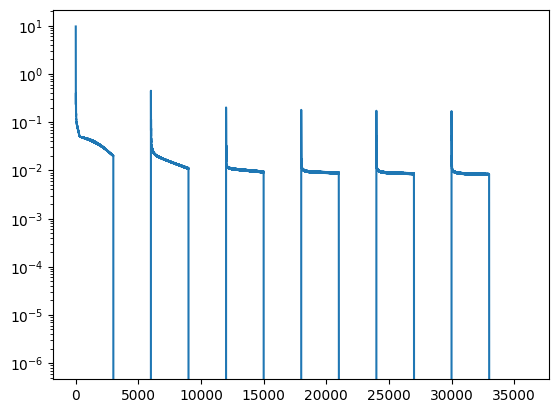

In [103]:
loss_hist = []
for step in range(1, 24000):
    sample_input, sample_target = sample_batch(inputs[step%2], targets[step%2], 4096, key0)
    #sample_target = sample_batch(, 4096, key0)
    if (step % 6000  < 3000):
        state, loss = train_step_ws(state, sample_input, sample_target, mu_filter, sigma_filter, w_filter, 5.0)
    #elif (step % 2 == 0):
    #    state, loss = train_step_kl1(state, sample_input, sample_target, mu_filter, sigma_filter, w_filter, 2.0)
    else:
        state, loss = train_step_kl3(state, sample_input, sample_target, mu_filter, sigma_filter, w_filter, 2.0)

    loss_hist.append(loss)
    if (step) % 3000 == 0:
        print(f'step: {step}, loss: {loss}')

plt.semilogy(loss_hist, label='loss')

In [29]:
def gaussian(x, mean, covariance):
    return (1.0 / jnp.sqrt(2 * jnp.pi * (covariance**2))) * jnp.exp(-0.5 * ((x - mean) ** 2) / (covariance**2))

# Define the GMM function
def gmm(x, weights, means, covariances):
    return sum([w * gaussian(x, m, c) for w, m, c in zip(weights, means, covariances)])

# Generate x values in the range [-1, 1]
x = jnp.linspace(-1, 1, 100)

def model_check(params, state, input, output, mu_filter, sigma_filter, w_filter, x):
    predicts = state.apply_fn(params, input)
    mu_predict = jnp.matmul(predicts, mu_filter).reshape(-1)
    print("mu_predict:", mu_predict)
    sigma_predict = jnp.exp(jnp.matmul(predicts, sigma_filter)).reshape(-1)
    print("sigma_predict:", sigma_predict)
    w_predict = jnp.matmul(predicts, w_filter).reshape(-1)
    print("wpredict:", w_predict)

    gmm_predict = [gmm(x0, w_predict, mu_predict, sigma_predict) for x0 in x]

    mu = jnp.matmul(output, mu_filter).reshape(-1)
    print("mu_target:", mu)
    sigma = jnp.exp(jnp.matmul(output, sigma_filter)).reshape(-1)
    print("sigma_target:", sigma)
    w = jnp.matmul(output, w_filter).reshape(-1)
    print("w_target:", w)
    gmm_target = [gmm(x0, w, mu, sigma) for x0 in x]
    #print(gmm_predict.shape)
    plt.plot(x, gmm_predict, label='predict')
    plt.plot(x, gmm_target, label='target')
    plt.legend()
    plt.show()
    #return gmm_predict, gmm_target

mu_predict: [-0.08548434 -0.11285811 -0.00394119 -0.0167364  -0.8678888 ]
sigma_predict: [ 1.9997693  1.799426   2.5693948  2.6241338 18.24015  ]
wpredict: [0.00243618 0.00331714 0.00704646 0.00907687 0.97812337]
mu_target: [ 0.2759522  0.4830886 -0.8539738 -0.4716806 -0.2592071]
sigma_target: [0.07939528 0.02737411 0.04574709 0.0626693  0.12590347]
w_target: [0.02064375 0.08300576 0.16674913 0.20448491 0.52511644]


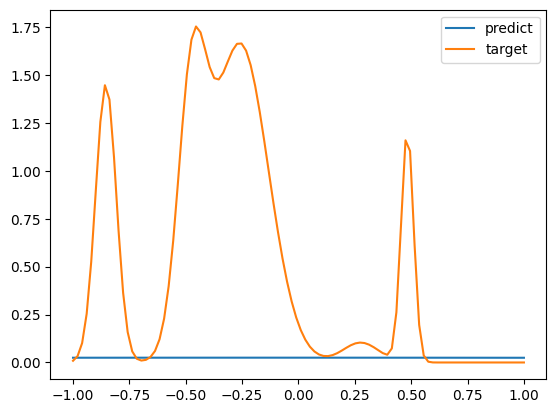

In [105]:
it = 34
#test_predict, test_target = model_check(state.params, state, input_data[it:it+1,:,:], target_data[it:it+1,1,:], mu_filter, sigma_filter, w_filter, x)
model_check(state.params, state, input_data[it:it+1,:,:], target_data[it:it+1,:,:], mu_filter, sigma_filter, w_filter, x)
#print(state.apply_fn(state.params, input_data[it:it+1,:,:]))
#print(target_data[it:it+1,:,:])
#print(test_predict[1])

In [94]:
class ScaleDot_test(nn.Module):
    head_dim: int
    """
    def scaled_dot_product_attention(self, q, k):
        #scores = jnp.matmul(q, jnp.transpose(k, (0, 2, 1)))
        scores = jnp.matmul(jnp.transpose(k, (0, 2, 1)), q)
        #w = nn.softmax(scores / jnp.sqrt(self.head_dim)) # *5
        w = nn.softmax(scores / jnp.sqrt(self.head_dim), axis=-2)
        #return jnp.matmul(w, v) # *6
        return w
    """

    @nn.compact
    def __call__(self, hidden_state):
        q = nn.Dense(features=self.head_dim)(hidden_state) # *1
        return q
        #k = nn.Dense(features=self.head_dim)(hidden_state) # *2
        #output = self.scaled_dot_product_attention(q, k)
        #return output

In [95]:
var = ScaleDot_test(8).init(key1, test)
#state = train_state.TrainState.create(apply_fn=model.TransformerEncoder(n_gauss, heads, d_model, n_layer).apply, params=var, tx=optax.chain(optax.scale_by_adam(), optax.scale_by_learning_rate(optax.piecewise_constant_schedule(init_value=1e-3, boundaries_and_scales={1000: 0.3}))))
state_test = train_state.TrainState.create(apply_fn=ScaleDot_test(8).apply, params=var, tx=optax.chain(optax.scale_by_adam(), optax.scale_by_learning_rate(optax.exponential_decay(1e-4, 3000, 0.5, end_value=1e-6))))

In [96]:
print(state_test.apply_fn(state_test.params, test).shape)
print(state_test.apply_fn(state_test.params, test))

(1, 1, 8)
[[[ 0.7276817  -0.4534678  -0.18004368  0.93782777 -1.2169051
    0.5180784  -0.9426379   0.92852926]]]


In [87]:
test =  jnp.asarray(random.normal(key0, (1, 1, 5)))
print(test)

[[[ 0.9087967  -0.040249    0.17204419 -1.6576358   0.353745  ]]]
